In [2]:
!pip install fastai
!pip install tensorboard

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image, ImageDraw, ImageFont
import random
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision
from torch.utils.data import Dataset, DataLoader
from torchvision.models import resnet34
import pytorch_lightning as pl
from sklearn.metrics import fbeta_score
from pytorch_lightning.callbacks.progress import TQDMProgressBar
import torch.nn.functional as F
from fastai.vision.all import *
import gc

In [2]:
train_attr = "Category and Attribute Prediction Benchmark\\Anno_fine\\train_attr.txt"
test_attr = "Category and Attribute Prediction Benchmark\\Anno_fine\\test_attr.txt"
train_img = "Category and Attribute Prediction Benchmark\\Anno_fine\\train.txt"
test_img = "Category and Attribute Prediction Benchmark\\Anno_fine\\test.txt"
train_bbox = "Category and Attribute Prediction Benchmark\\Anno_fine\\train_bbox.txt"
test_bbox = "Category and Attribute Prediction Benchmark\\Anno_fine\\test_bbox.txt"

In [3]:
attributes = ['floral', 'graphic', 'striped', 'embroidered', 'pleated', 'solid', 'lattice', 'long_sleeve', 'short_sleeve',
              'sleeveless', 'maxi_length', 'mini_length', 'no_dress', 'crew_neckline', 'v_neckline', 'square_neckline',
              'no_neckline', 'denim', 'chiffon', 'cotton', 'leather', 'faux', 'knit', 'tight', 'loose', 'conventional']

In [4]:
train_img = pd.read_csv(train_img, header=None, names=['image_path'], delimiter=' ', index_col=False)
test_img = pd.read_csv(test_img, header=None, names=['image_path'], delimiter=' ', index_col=False)
train_attr = pd.read_csv(train_attr, header=None, delimiter=' ', names = attributes, index_col=False)
test_attr = pd.read_csv(test_attr, header=None, delimiter=' ', names = attributes, index_col=False)
train_bbox = pd.read_csv(train_bbox, header=None, delimiter=' ', names = ['x1', 'y1', 'x2', 'y2'], index_col=False)
test_bbox = pd.read_csv(test_bbox, header=None, delimiter=' ', names = ['x1', 'y1', 'x2', 'y2'], index_col=False)

In [5]:
for i in train_img, test_img, train_attr, test_attr, train_bbox, test_bbox:
    print(i.shape)

(14000, 1)
(4000, 1)
(14000, 26)
(4000, 26)
(14000, 4)
(4000, 4)


In [6]:
train_img.reset_index(inplace=True)
train_attr.reset_index(inplace=True)
train_bbox.reset_index(inplace=True)
test_img.reset_index(inplace=True)
test_attr.reset_index(inplace=True)
test_bbox.reset_index(inplace=True)

In [7]:
train_df = train_img.merge(train_attr, on='index').merge(train_bbox, on='index')
test_df = test_img.merge(test_attr, on='index').merge(test_bbox, on='index')

In [8]:
train_df.head()

,index,image_path,floral,graphic,striped,embroidered,pleated,solid,lattice,long_sleeve,...,leather,faux,knit,tight,loose,conventional,x1,y1,x2,y2
0,0,img/Sweet_Crochet_Blouse/img_00000070.jpg,0,0,0,1,0,0,0,0,...,0,0,0,0,0,1,66,75,241,293
1,1,img/Classic_Pencil_Skirt/img_00000010.jpg,0,0,0,0,0,1,0,0,...,0,0,0,1,0,0,65,88,132,218
2,2,img/Strapless_Diamond_Print_Dress/img_00000038.jpg,0,1,0,0,0,0,0,0,...,0,0,0,0,0,1,75,43,176,300
3,3,img/Mid-Rise_-_Acid_Wash_Skinny_Jeans/img_00000010.jpg,0,0,0,0,0,1,0,0,...,0,0,0,1,0,0,64,1,129,273
4,4,img/Zippered_Single-Button_Blazer/img_00000078.jpg,0,0,0,0,0,1,0,1,...,0,0,0,0,0,1,1,12,257,300


In [9]:
ind = 17

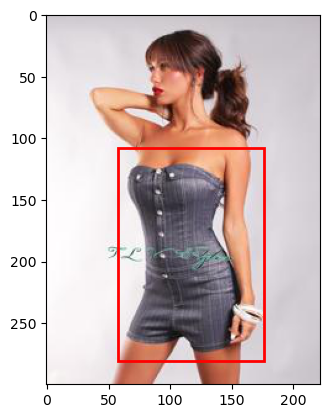

In [12]:
image_path = train_df.iloc[ind][1]
image = Image.open(image_path)
fig, ax = plt.subplots()
ax.imshow(image)
x1, y1, x2, y2 = train_df.iloc[ind][-4], train_df.iloc[ind][-3], train_df.iloc[ind][-2], train_df.iloc[ind][-1]
bbox = patches.Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=2, edgecolor='r', facecolor='none')
ax.add_patch(bbox)
plt.show()

In [10]:
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    #transforms.RandomRotation(degrees=20),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Обновление пользовательского датасета с применением аугментаций к изображениям
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        image_path = self.dataframe.iloc[idx]['image_path']
        image = Image.open(image_path)
        x1, y1 = (train_df.iloc[idx][-4], train_df.iloc[idx][-3])  # координаты левой верхней точки
        x2, y2 = (train_df.iloc[idx][-2], train_df.iloc[idx][-1])  # координаты правой нижней точки
        image = image.crop((x1, y1, x2, y2))
        if self.transform:
            image = self.transform(image)
        attributes = self.dataframe.iloc[idx, 2:28].values.astype(float)
        return image, attributes

In [11]:
dataset = CustomDataset(train_df, transform=transform)
train_loader = DataLoader(dataset, batch_size=128, shuffle=True)

In [12]:
test_dataset = CustomDataset(test_df, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


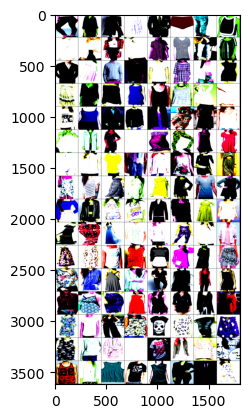

In [13]:
def imshow(img, title=None):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    if title is not None:
        plt.title(title)
    plt.show()

data_iter = iter(train_loader)
images, _ = next(data_iter)

imshow(torchvision.utils.make_grid(images))

In [14]:
train_loss_mean = []
train_acc_mean = []
val_loss_mean = []
val_accuracy_mean = []
val_k_acc = []

In [15]:
class LabelSmoothingBCEWithLogitsLossFlat(BCEWithLogitsLossFlat):
    def __init__(self, eps:float=0.1, **kwargs):
        self.eps = eps
        super().__init__(thresh=0.2, **kwargs)

    def __call__(self, inp, targ, **kwargs):
        # https://www.kaggle.com/c/siim-isic-melanoma-classification/discussion/166833#929222
        targ_smooth = targ.float() * (1. - self.eps) + 0.5 * self.eps
        return super().__call__(inp, targ_smooth, **kwargs)

In [16]:
class CustomResNet(nn.Module):
    def __init__(self, num_classes=26):
        super(CustomResNet, self).__init__()
        resnet = resnet34(weights=ResNet34_Weights.IMAGENET1K_V1)
        for param in resnet.parameters():
            param.requires_grad = False
        in_features = resnet.fc.in_features
        resnet.fc = nn.Linear(in_features, num_classes)
        self.resnet = resnet

    def forward(self, x):
        return self.resnet(x)

# Определение PyTorch Lightning модели
class CustomModel(pl.LightningModule):
    def __init__(self, model, threshold = 0.6, k = 3):
        super(CustomModel, self).__init__()
        self.model = model
        self.train_loss_mean = []
        self.train_acc_mean = []
        self.train_k_acc = []
        self.val_loss_mean = []
        self.val_acc_mean = []
        self.val_k_acc = []
        self.k = k
        self.threshold = threshold

    def adversarial_loss(self, y_hat, y):
        loss_fn = LabelSmoothingBCEWithLogitsLossFlat()
        return loss_fn(y_hat, y)
    
    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        images, attributes = batch
        outputs = self(images)
        loss = self.adversarial_loss(outputs, attributes)
        self.train_loss_mean.append(loss)
        accuracy = self.calculate_accuracy(outputs, attributes)
        k_acc = self.top_k_accuracy(outputs, attributes)
        self.train_acc_mean.append(accuracy)
        self.train_k_acc.append(k_acc)
        print(batch_idx, loss.item(), accuracy, k_acc)
        return loss

    def validation_step(self, batch, batch_idx):
        images, attributes = batch
        outputs = self(images)
        loss = self.adversarial_loss(outputs, attributes)
        self.val_loss_mean.append(loss)
        accuracy = self.calculate_accuracy(outputs, attributes)
        k_acc = self.top_k_accuracy(outputs, attributes)
        self.val_acc_mean.append(accuracy)
        self.val_k_acc.append(k_acc)
        return {"val_loss": loss, "val_accuracy": accuracy, "val_k_acc": k_acc}

    def configure_optimizers(self):
        return torch.optim.Adam(self.model.parameters(), lr=0.001)
        
    def on_validation_epoch_end(self):
        print('val epoch end')
        loss = sum(self.val_loss_mean)/len(self.val_loss_mean)
        self.val_loss_mean = []
        acc = sum(self.val_acc_mean)/len(self.val_acc_mean)
        self.val_acc_mean = []
        k_acc = sum(self.val_k_acc)/len(self.val_k_acc)
        self.val_k_acc = []
        self.log("val epoch end loss",loss, prog_bar=True)
        self.log("val epoch end acc",acc, prog_bar=True)
        self.log("val epoch end k acc",k_acc, prog_bar=True)

    def calculate_accuracy(self, outputs, targets):
        probs = F.softmax(outputs, dim=1)
        binary_mask = (probs >= self.threshold).float()
        accuracy = fbeta_score(binary_mask, targets, beta=2, average='samples')
        return accuracy

    def on_train_epoch_end(self):
        loss = sum(self.train_loss_mean)/len(self.train_loss_mean)
        self.train_loss_mean = []
        acc = sum(self.train_acc_mean)/len(self.train_acc_mean)
        self.train_acc_mean = []
        k_acc = sum(self.train_k_acc)/len(self.train_k_acc)
        self.train_k_acc = []
        self.log("train epoch end loss",loss, prog_bar=True)
        self.log("train epoch end acc",acc, prog_bar=True)
        self.log("train epoch end k acc",k_acc, prog_bar=True)
    
    def top_k_accuracy(self, outputs, targets):
        topk_values, topk_indices = torch.topk(outputs, self.k, dim=1)
        correct_count = 0
        for i in range(topk_indices.size(0)):
            for j in range(topk_indices.size(1)):
                if targets[i, topk_indices[i, j]] == 1:
                    correct_count += 1
        accuracy = correct_count / (outputs.size(0)*self.k)
        return accuracy


# Инициализация модели и тренировка
model = CustomResNet()
custom_model = CustomModel(model)
trainer = pl.Trainer(
    accelerator="auto", 
    max_epochs= 10,
    callbacks=[TQDMProgressBar(refresh_rate=20)],
)
trainer.fit(custom_model, train_loader, test_loader)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type         | Params
---------------------------------------
0 | model | CustomResNet | 21.3 M
---------------------------------------
13.3 K    Trainable params
21.3 M    Non-trainable params
21.3 M    Total params
85.192    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

val epoch end


Training: 0it [00:00, ?it/s]

0 0.7443360686302185 0.0 0.2421875
1 0.620568037033081 0.0 0.4609375
2 0.5517858862876892 0.0 0.640625
3 0.5070353746414185 0.0 0.7057291666666666
4 0.4840856194496155 0.0 0.734375
5 0.47691822052001953 0.0 0.75
6 0.48595964908599854 0.015625 0.734375
7 0.5203707814216614 0.03515625 0.6796875
8 0.5069205164909363 0.07421875 0.7213541666666666
9 0.5096169710159302 0.1015625 0.7005208333333334
10 0.49195927381515503 0.1328125 0.7369791666666666
11 0.48035284876823425 0.125 0.7291666666666666
12 0.4947143793106079 0.1015625 0.7239583333333334
13 0.49362415075302124 0.08984375 0.7161458333333334
14 0.4654999077320099 0.06640625 0.7942708333333334
15 0.48109880089759827 0.02734375 0.7109375
16 0.4786722958087921 0.015625 0.7552083333333334
17 0.47616955637931824 0.01953125 0.7526041666666666
18 0.47374725341796875 0.0078125 0.7395833333333334
19 0.46731629967689514 0.0078125 0.7604166666666666
20 0.4663369357585907 0.0 0.796875
21 0.4594474136829376 0.0 0.7578125
22 0.47510620951652527 0.0 

Validation: 0it [00:00, ?it/s]

val epoch end
0 0.41440248489379883 0.01171875 0.8020833333333334
1 0.4010795056819916 0.0078125 0.8359375
2 0.39274710416793823 0.00390625 0.8567708333333334
3 0.38479694724082947 0.0 0.8567708333333334
4 0.39967265725135803 0.0 0.8307291666666666
5 0.3915121853351593 0.01171875 0.8645833333333334
6 0.40004536509513855 0.015625 0.8567708333333334
7 0.3986961245536804 0.01171875 0.8671875
8 0.38485416769981384 0.015625 0.859375
9 0.3874569535255432 0.015625 0.8697916666666666
10 0.39448896050453186 0.015625 0.8411458333333334
11 0.3961057662963867 0.0078125 0.8307291666666666
12 0.3913322687149048 0.01171875 0.875
13 0.3941606283187866 0.00390625 0.8463541666666666
14 0.39733630418777466 0.015625 0.8515625
15 0.40133997797966003 0.0078125 0.8177083333333334
16 0.38433024287223816 0.0078125 0.8385416666666666
17 0.39081698656082153 0.00390625 0.8723958333333334
18 0.4005798101425171 0.01171875 0.8307291666666666
19 0.38625434041023254 0.00390625 0.859375
20 0.3889206647872925 0.015625 0

Validation: 0it [00:00, ?it/s]

val epoch end
0 0.3853188157081604 0.0078125 0.8671875
1 0.3735685348510742 0.015625 0.859375
2 0.3812648355960846 0.00390625 0.8671875
3 0.37684109807014465 0.01171875 0.8645833333333334
4 0.3849273920059204 0.01171875 0.8619791666666666
5 0.3860090374946594 0.0234375 0.859375
6 0.4046315848827362 0.05078125 0.8177083333333334
7 0.37881749868392944 0.0390625 0.8671875
8 0.38705796003341675 0.046875 0.8385416666666666
9 0.37782055139541626 0.03515625 0.8802083333333334
10 0.38920462131500244 0.0234375 0.84375
11 0.38157016038894653 0.0390625 0.8567708333333334
12 0.3804011344909668 0.03515625 0.8802083333333334
13 0.3778330981731415 0.02734375 0.8541666666666666
14 0.3822830021381378 0.03515625 0.8359375
15 0.3688943088054657 0.0234375 0.890625
16 0.37314435839653015 0.01171875 0.8880208333333334
17 0.38444021344184875 0.01953125 0.8567708333333334
18 0.3838560879230499 0.01171875 0.859375
19 0.3770400285720825 0.01171875 0.8932291666666666
20 0.36899533867836 0.01953125 0.890625
21 0.

Validation: 0it [00:00, ?it/s]

val epoch end
0 0.3757403492927551 0.03125 0.8645833333333334
1 0.3781510591506958 0.03125 0.8671875
2 0.3722987473011017 0.0390625 0.8828125
3 0.38034069538116455 0.0234375 0.8385416666666666
4 0.38725602626800537 0.046875 0.8489583333333334
5 0.3692478835582733 0.01953125 0.8411458333333334
6 0.3658125698566437 0.03125 0.8723958333333334
7 0.3889206349849701 0.0625 0.8489583333333334
8 0.3758777379989624 0.046875 0.8828125
9 0.3654792010784149 0.03515625 0.8958333333333334
10 0.3691675066947937 0.02734375 0.8802083333333334
11 0.36575847864151 0.0546875 0.9010416666666666
12 0.3724902272224426 0.03515625 0.8671875
13 0.3630642890930176 0.02734375 0.8958333333333334
14 0.36444026231765747 0.0546875 0.8671875
15 0.37700891494750977 0.0390625 0.8515625
16 0.37917473912239075 0.0703125 0.8697916666666666
17 0.3850817382335663 0.0546875 0.84375
18 0.387259840965271 0.02734375 0.8333333333333334
19 0.379183828830719 0.02734375 0.859375
20 0.3645283877849579 0.01953125 0.9114583333333334
21

Validation: 0it [00:00, ?it/s]

val epoch end
0 0.366191029548645 0.0546875 0.8854166666666666
1 0.3664853870868683 0.046875 0.8880208333333334
2 0.3689640462398529 0.0390625 0.875
3 0.3734826445579529 0.0234375 0.8776041666666666
4 0.3737643361091614 0.0390625 0.8645833333333334
5 0.36934536695480347 0.05078125 0.8828125
6 0.3622592091560364 0.0390625 0.890625
7 0.3793916702270508 0.04296875 0.8802083333333334
8 0.3580520451068878 0.03515625 0.9088541666666666
9 0.379865825176239 0.04296875 0.8541666666666666
10 0.379316121339798 0.0234375 0.8567708333333334
11 0.37130627036094666 0.04296875 0.8671875
12 0.37030813097953796 0.015625 0.8567708333333334
13 0.36537325382232666 0.03515625 0.8854166666666666
14 0.37847501039505005 0.0390625 0.875
15 0.3682558238506317 0.03515625 0.8880208333333334
16 0.3570890426635742 0.04296875 0.9036458333333334
17 0.368040531873703 0.03515625 0.8854166666666666
18 0.3704027533531189 0.078125 0.8880208333333334
19 0.3631128668785095 0.046875 0.8880208333333334
20 0.3628261983394623 0.

Validation: 0it [00:00, ?it/s]

val epoch end
0 0.36993613839149475 0.078125 0.890625
1 0.3690386116504669 0.07421875 0.8802083333333334
2 0.37325313687324524 0.0703125 0.8515625
3 0.37630704045295715 0.07421875 0.8541666666666666
4 0.36464861035346985 0.03515625 0.8645833333333334
5 0.3484504520893097 0.03515625 0.9088541666666666
6 0.360221803188324 0.03125 0.8828125
7 0.35511067509651184 0.02734375 0.9010416666666666
8 0.3756619691848755 0.03125 0.8802083333333334
9 0.37081483006477356 0.03125 0.8697916666666666
10 0.36723944544792175 0.05078125 0.8723958333333334
11 0.3647473156452179 0.03515625 0.8645833333333334
12 0.3791327476501465 0.0390625 0.8619791666666666
13 0.3727416396141052 0.01953125 0.8723958333333334
14 0.3583795130252838 0.046875 0.8958333333333334
15 0.36924347281455994 0.04296875 0.8828125
16 0.3700397312641144 0.0390625 0.8619791666666666
17 0.3744882345199585 0.046875 0.859375
18 0.38197967410087585 0.046875 0.8333333333333334
19 0.36371320486068726 0.03125 0.8932291666666666
20 0.369394898414

Validation: 0it [00:00, ?it/s]

val epoch end
0 0.36834728717803955 0.0703125 0.8854166666666666
1 0.3753416836261749 0.06640625 0.8880208333333334
2 0.36440563201904297 0.08203125 0.8958333333333334
3 0.37372857332229614 0.046875 0.8619791666666666
4 0.3681669533252716 0.09765625 0.8802083333333334
5 0.3749619126319885 0.03515625 0.8671875
6 0.369014710187912 0.03515625 0.890625
7 0.36484941840171814 0.046875 0.859375
8 0.3515155613422394 0.04296875 0.9348958333333334
9 0.36313337087631226 0.0234375 0.8880208333333334
10 0.35576561093330383 0.046875 0.8880208333333334
11 0.3784882724285126 0.05859375 0.8541666666666666
12 0.3586883544921875 0.05078125 0.8880208333333334
13 0.38173484802246094 0.0546875 0.8411458333333334
14 0.36044055223464966 0.046875 0.90625
15 0.36823490262031555 0.0546875 0.875
16 0.3720245659351349 0.04296875 0.8776041666666666
17 0.3719528615474701 0.04296875 0.859375
18 0.3693380355834961 0.02734375 0.8567708333333334
19 0.3686895966529846 0.03125 0.8854166666666666
20 0.36428552865982056 0.0

Validation: 0it [00:00, ?it/s]

val epoch end
0 0.3748590648174286 0.03515625 0.8541666666666666
1 0.36623749136924744 0.06640625 0.8828125
2 0.3516198694705963 0.04296875 0.8932291666666666
3 0.3541353642940521 0.03515625 0.890625
4 0.3623351454734802 0.02734375 0.890625
5 0.3579428791999817 0.0546875 0.8828125
6 0.3651793599128723 0.0859375 0.8776041666666666
7 0.3814525008201599 0.04296875 0.8541666666666666
8 0.365202933549881 0.08984375 0.8776041666666666
9 0.3595309853553772 0.06640625 0.8880208333333334
10 0.37289097905158997 0.07421875 0.8489583333333334
11 0.3601110875606537 0.07421875 0.8645833333333334
12 0.3650137484073639 0.0546875 0.890625
13 0.38618505001068115 0.078125 0.8645833333333334
14 0.3719734847545624 0.0546875 0.8671875
15 0.3544045090675354 0.046875 0.9114583333333334
16 0.36644813418388367 0.046875 0.8880208333333334
17 0.3575615882873535 0.0390625 0.9114583333333334
18 0.36642757058143616 0.03515625 0.8723958333333334
19 0.35221952199935913 0.05078125 0.90625
20 0.3488280475139618 0.03125 

Validation: 0it [00:00, ?it/s]

val epoch end
0 0.36778831481933594 0.06640625 0.8645833333333334
1 0.3674589991569519 0.07421875 0.8880208333333334
2 0.3600028157234192 0.02734375 0.8854166666666666
3 0.3669506907463074 0.05078125 0.8697916666666666
4 0.36387956142425537 0.03515625 0.8776041666666666
5 0.36122259497642517 0.0625 0.8958333333333334
6 0.35989058017730713 0.05859375 0.8984375
7 0.37747547030448914 0.05078125 0.8489583333333334
8 0.37180912494659424 0.05859375 0.8671875
9 0.371584415435791 0.04296875 0.8697916666666666
10 0.35216623544692993 0.05859375 0.9140625
11 0.3625035881996155 0.0625 0.9010416666666666
12 0.3543017506599426 0.05078125 0.8984375
13 0.3533850312232971 0.046875 0.9244791666666666
14 0.38507401943206787 0.04296875 0.8385416666666666
15 0.3541034460067749 0.03515625 0.8880208333333334
16 0.3640668988227844 0.05078125 0.8645833333333334
17 0.3716592490673065 0.0625 0.8697916666666666
18 0.35510367155075073 0.07421875 0.9010416666666666
19 0.358901709318161 0.078125 0.8984375
20 0.37120

Validation: 0it [00:00, ?it/s]

val epoch end
0 0.36650604009628296 0.046875 0.875
1 0.3612160086631775 0.05078125 0.8645833333333334
2 0.36754095554351807 0.0859375 0.8828125
3 0.35770851373672485 0.07421875 0.875
4 0.3707713484764099 0.08203125 0.8828125
5 0.3608839809894562 0.0625 0.875
6 0.36166876554489136 0.06640625 0.8984375
7 0.36917272210121155 0.0546875 0.859375
8 0.36037394404411316 0.06640625 0.9010416666666666
9 0.3687485456466675 0.07421875 0.8854166666666666
10 0.3608051538467407 0.0703125 0.8880208333333334
11 0.3664838969707489 0.0703125 0.8697916666666666
12 0.36836570501327515 0.07421875 0.8723958333333334
13 0.3642553687095642 0.05859375 0.8828125
14 0.3645073473453522 0.02734375 0.8776041666666666
15 0.35569140315055847 0.05078125 0.8828125
16 0.3740540146827698 0.04296875 0.8645833333333334
17 0.35986775159835815 0.04296875 0.890625
18 0.35808438062667847 0.0546875 0.890625
19 0.3650630712509155 0.03515625 0.8802083333333334
20 0.36065953969955444 0.02734375 0.8671875
21 0.3449060618877411 0.050

Validation: 0it [00:00, ?it/s]

val epoch end


`Trainer.fit` stopped: `max_epochs=10` reached.


In [23]:
%tensorboard --logdir lightning_logs/ --port 6006
%tensorboard --logdir lightning_logs/

Reusing TensorBoard on port 6006 (pid 31300), started 1 day, 6:20:29 ago. (Use '!kill 31300' to kill it.)

In [17]:
torch.save(custom_model.model.state_dict(), 'saved_model.pth')

In [18]:
mod = CustomResNet()
cust_model = CustomModel(mod)
cust_model.model.load_state_dict(torch.load('saved_model.pth'))

<All keys matched successfully>

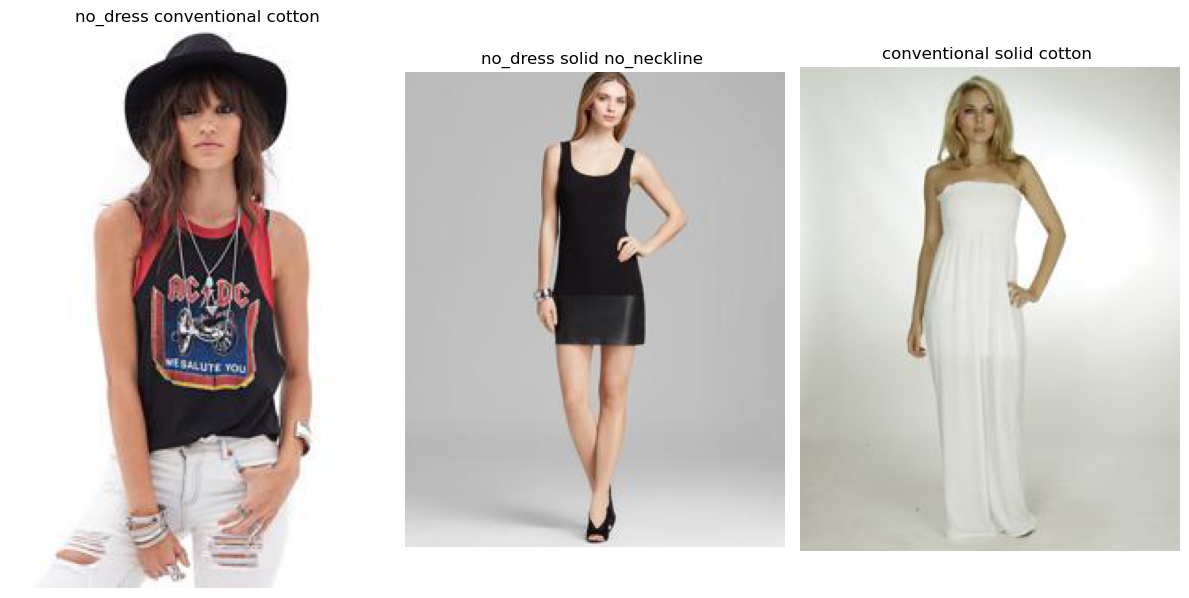

In [55]:
random_indices = random.sample(range(len(test_df)), 3)
random_test_df = test_df.loc[random_indices, ::]
dataset = CustomDataset(random_test_df, transform=transform)
random_test_loader = DataLoader(dataset, batch_size=5, shuffle=False)
attributes = test_df.columns[2:28]
for batch_idx, (inputs, targets) in enumerate(random_test_loader):
    with torch.no_grad():
        outputs = custom_model.model(inputs)
    topk_values, topk_indices = torch.topk(outputs, 3, dim=1)
    images = [Image.open(image_path) for image_path in random_test_df.image_path]
    captions = []
    for i in range(topk_indices.size(0)):
        label = ""
        for j in range(topk_indices.size(1)):
            label += f'{attributes[topk_indices[i, j].item()]} '
        captions.append(label)
        
    plt.figure(figsize=(12, 6))
    for i, (image, label) in enumerate(zip(images, captions)):
        plt.subplot(1, len(images), i+1)
        plt.imshow(image)
        plt.axis('off')
        plt.title(label, fontsize=12)

    plt.tight_layout()
    plt.show()